## Quantum Exponential Distribution

1. Initialize quantum register `q[0 to num_qubits + 1]`
2. Initialize classical register `c[0 to num_qubits - 1]`
3. Initialize quantum circuit `qc` with `q` and `c`

4. Compute rotation angle:  
   `theta ← 2 * arccos( sqrt(decay / (decay+1)) )`   ← Exponential distribution for different decay rate

5. Apply `X` gate to `q[1]`                        ← Initialize second qubit to |1⟩

6. For `block` in `1` to `num_qubits - 1`:

    a. Apply `RX(theta)` gate to ancilla qubit `q[0]`

    b. For `swap` in `1` to `block - 1`: <br>  
    1.   Apply `CSWAP` with control `q[0]` on `(q[swap], q[num_qubits + 1])`
    2.  Reset qubit `q[num_qubits + 1]` to |0⟩ <br>

    c. Apply final `CSWAP` with control `q[0]` on `(q[block], q[block + 1])`

    d. Reset ancilla qubit `q[0]` to |0⟩

7. For `i` in `1` to `num_qubits`:
    Measure `q[i]` into classical bit `c[i - 1]`

8. Return the quantum circuit `qc`



Measurement Probabilities:
  State |00000001>: 0.6307
  State |00000010>: 0.2332
  State |00000100>: 0.0858
  State |00001000>: 0.0293
  State |00010000>: 0.0141
  State |00100000>: 0.0046
  State |01000000>: 0.0017
  State |10000000>: 0.0007


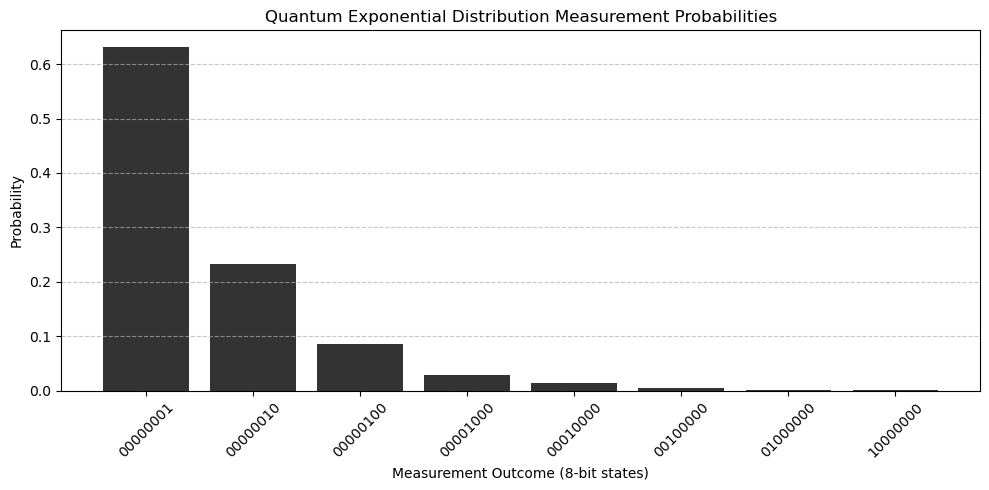

In [7]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np


def build_quantum_exponential_distribution_circuit(num_qubits: int, decay) -> QuantumCircuit:
    """
    Constructs the quantum exponential distribution circuit using RX and CSWAP gates.
    
    Parameters:
        num_qubits (int): Number of qubits used for encoding the distribution.
        decay (float): Decay rate for exponential distribution.

    Returns:
        QuantumCircuit: The constructed quantum circuit.
    """
    # Define quantum and classical registers
    q = QuantumRegister(num_qubits + 2, 'q')  # +2 for ancilla qubits: q[0] and q[num_qubits+1]
    c = ClassicalRegister(num_qubits, 'c')    # Classical bits to record measurements
    qc = QuantumCircuit(q, c)

    # Rotation angle to approximate exponential distribution
    theta = 2 * np.arccos(np.sqrt(decay / (1 + decay)))  # Example for different decay rates

    # Set the second qubit (q[1]) to |1⟩ as initial state
    qc.x(q[1])

    # Apply RX and CSWAP blocks to spread amplitude
    for block in range(1, num_qubits):
        qc.rx(theta, q[0])  # Apply RX gate on ancilla q[0]

        # Nested CSWAPs using q[num_qubits+1] as temporary ancilla
        for swap in range(1, block):
            qc.cswap(q[0], q[swap], q[num_qubits + 1])
            qc.reset(q[num_qubits + 1])

        # Final CSWAP step
        qc.cswap(q[0], q[block], q[block + 1])
        qc.reset(q[0])  # Reset main control ancilla q[0]

    # Measure q[1] through q[num_qubits] into classical register
    for i in range(1, num_qubits + 1):
        qc.measure(q[i], c[i - 1])

    return qc


def run_simulation(qc: QuantumCircuit, shots: int = 100000) -> dict:
    """
    Simulates the quantum circuit and returns measurement results.

    Parameters:
        qc (QuantumCircuit): The quantum circuit to simulate.
        shots (int): Number of repetitions.

    Returns:
        dict: Measurement counts.
    """
    simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit, shots=shots).result()
    return result.get_counts(qc)


def calculate_probabilities(counts: dict, num_qubits: int) -> dict:
    """
    Calculates normalized measurement probabilities from counts,
    excluding the all-zero state and properly normalizing.

    Parameters:
        counts (dict): Raw counts from simulation.
        num_qubits (int): Number of qubits measured.

    Returns:
        dict: Properly normalized probabilities (excluding all-zero state).
    """
    # Remove the all-zero state if present
    zero_state = '0' * num_qubits
    filtered_counts = {
        state: count for state, count in counts.items() if state != zero_state
    }

    total = sum(filtered_counts.values())
    return {
        state: count / total for state, count in filtered_counts.items()
    }


def plot_probabilities(probabilities: dict, num_qubits: int):
    """
    Plots the sorted probability distribution from simulation results.

    Parameters:
        probabilities (dict): Probability values from measurement outcomes.
        num_qubits (int): Number of qubits measured (used for labeling).
    """
    if not probabilities:
        print("No measurement outcomes to plot.")
        return

    # Sort outcomes by integer value
    sorted_states = sorted(probabilities.keys(), key=lambda x: int(x, 2))
    sorted_probs = [probabilities[state] for state in sorted_states]

    plt.figure(figsize=(10, 5))
    plt.bar(sorted_states, sorted_probs, color='black', alpha=0.8)
    plt.xlabel(f"Measurement Outcome ({num_qubits}-bit states)")
    plt.ylabel("Probability")
    plt.title("Quantum Exponential Distribution Measurement Probabilities")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


def main(num_qubits=8, decay=2.718, shots=100000):
    """
    Main execution function: builds circuit, simulates it, computes and plots results.

    Parameters:
        num_qubits (int): Number of qubits to use for the distribution.
        shots (int): Number of simulation repetitions.
    """
    qc = build_quantum_exponential_distribution_circuit(num_qubits, decay)  # Example decay rate
    counts = run_simulation(qc, shots)
    probabilities = calculate_probabilities(counts, num_qubits)

    print("\nMeasurement Probabilities:")
    for state, prob in sorted(probabilities.items()):
        print(f"  State |{state}>: {prob:.4f}")

    plot_probabilities(probabilities, num_qubits)


if __name__ == "__main__":
    main()
